I'll follow classification process with https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/notebooks/TripletMarginLossMNIST.ipynb

In [27]:
import time
import logging 

import torch
import torch.nn as nn

from torchtext.datasets import AG_NEWS, SogouNews
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pytorch_metric_learning
from pytorch_metric_learning import losses, miners, samplers, distances, testers, reducers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)

INFO:root:VERSION 0.9.98


_____

In [2]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
        
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [3]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True) # embedding + averaging
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return embedded
    
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [4]:
def train(cur_epoch, dataloader, mining_func):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        embeddings = model(text, offsets)        
        indices_tuple = mining_func(embeddings, label)
        loss = loss_func(embeddings, label, indices_tuple)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
    print("Current Epoch {} : Loss = {}, Number of mined triplets = {}".format(cur_epoch, loss, mining_func.num_triplets))

def get_all_embeddings(loader, model):
    model.eval()
    emb_container = []
    label_container = []

    for idx, (label, text, offsets) in enumerate(loader):
        emb = model(text, offsets)
        emb_container.append(emb.cpu())
        label_container.append(label.cpu())

    x,y = torch.cat(emb_container), torch.cat(label_container)
    return x.detach(), y.detach()

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def evaluate(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

____

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv('.data/DBpedia/train.csv')
test_df = pd.read_csv('.data/DBpedia/test.csv')
valid_df = pd.read_csv('.data/DBpedia/valid.csv')

In [7]:
label_dict = {v:k for k,v in enumerate(train_df['l3'].unique())}

In [8]:
train_iter = iter(list(zip(train_df['l3'].map(lambda x : label_dict[x]).tolist(), train_df['text'].tolist())))

____

In [9]:
tokenizer = get_tokenizer('basic_english')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(device)

# set vocab size
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

cuda


In [10]:
# load nn.Module object
# train_iter = AG_NEWS(split='train')
train_iter = iter(list(zip(train_df['l3'].tolist(), train_df['text'].tolist())))
num_class = len(set([label for (label, text) in train_iter])); print(num_class)
vocab_size = len(vocab); print(vocab_size)
emsize = 32
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

219
628321


In [11]:
train_iter = iter(list(zip(train_df['l3'].map(lambda x : label_dict[x]).tolist(), train_df['text'].tolist())))
valid_iter = iter(list(zip(valid_df['l3'].map(lambda x : label_dict[x]).tolist(), valid_df['text'].tolist())))
test_iter = iter(list(zip(test_df['l3'].map(lambda x : label_dict[x]).tolist(), test_df['text'].tolist())))

In [12]:
EPOCHS = 50 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

______

In [13]:
### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 20)

In [14]:
num_epochs = 10 # epoch

for epoch in range(1, num_epochs+1):
    train(epoch, train_dataloader, mining_func)
    evaluate(train_dataloader, test_dataloader, model, accuracy_calculator)

Current Epoch 1 : Loss = 0.08084768056869507, Number of mined triplets = 4
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.7220449386452611
Current Epoch 2 : Loss = 0.08033990859985352, Number of mined triplets = 24
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.7787939599302562
Current Epoch 3 : Loss = 0.09155242145061493, Number of mined triplets = 30
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8117248412672303
Current Epoch 4 : Loss = 0.0937754362821579, Number of mined triplets = 35
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8277297101687666
Current Epoch 5 : Loss = 0.0509636290371418, Number of mined triplets = 7
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8434055992367668
Current Epoch 6 : Loss = 0.0, Number of mined triplets = 0
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8504786656577952


KeyboardInterrupt: 

____

### generate out of distribution

In [ ]:
out_train_data, out_test_data = AG_NEWS()
out_train_dataset = to_map_style_dataset(out_train_data)
out_test_dataset = to_map_style_dataset(out_test_data)
out_train_dataloader = DataLoader(out_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
out_test_dataloader = DataLoader(out_test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [16]:
label_dict = {1 : 'World',
2 : 'Sports',
3 : 'Business',
4 : "Sci/Tec"}

____

# Fine-tuning

In [17]:
from cycler import cycler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [18]:
class FineTuningModel(nn.Module):

    def __init__(self,
                 n_embed=10000,
                 d_embed=32,
                 d_hidden1=64,
                 d_hidden2=4,
                 d_out=2,
                 dp=0.2,
                 pretrained=None):
        super(FineTuningModel, self).__init__()
        
        self.embed = pretrained
        self.dropout1 = nn.Dropout(dp)
        self.bn1 = nn.BatchNorm1d(d_embed)
        self.fc1 = nn.Linear(d_embed, d_hidden1)
        self.dropout2 = nn.Dropout(dp)
        self.bn2 = nn.BatchNorm1d(d_hidden1)
        self.fc2 = nn.Linear(d_hidden1, d_hidden2)

    def forward(self, text, offsets):
        x = self.embed(text, offsets)

        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = torch.tanh(self.fc2(x))

        return x

In [19]:
fine_tuning_model = FineTuningModel(pretrained=model).to(device)

In [20]:
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

In [21]:
def fine_tune(dataloader):
    fine_tuning_model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        label = label - 1
        optimizer.zero_grad()
        predited_label = fine_tuning_model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fine_tuning_model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    fine_tuning_model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            label = label - 1
            predited_label = fine_tuning_model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [22]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    fine_tune(out_train_dataloader)
    accu_val = evaluate(out_test_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1875 batches | accuracy    0.712
| epoch   1 |  1000/ 1875 batches | accuracy    0.806
| epoch   1 |  1500/ 1875 batches | accuracy    0.834
-----------------------------------------------------------
| end of epoch   1 | time: 18.77s | valid accuracy    0.871 
-----------------------------------------------------------
| epoch   2 |   500/ 1875 batches | accuracy    0.863
| epoch   2 |  1000/ 1875 batches | accuracy    0.867
| epoch   2 |  1500/ 1875 batches | accuracy    0.873
-----------------------------------------------------------
| end of epoch   2 | time: 17.61s | valid accuracy    0.883 
-----------------------------------------------------------
| epoch   3 |   500/ 1875 batches | accuracy    0.882
| epoch   3 |  1000/ 1875 batches | accuracy    0.886
| epoch   3 |  1500/ 1875 batches | accuracy    0.885
-----------------------------------------------------------
| end of epoch   3 | time: 16.27s | valid accuracy    0.891 
-------------------------------

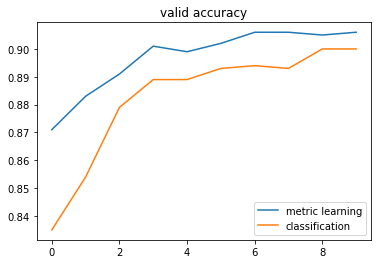

In [26]:
plt.title("valid accuracy")
plt.plot([0.871, 0.883 , 0.891 , 0.901, 0.899, 0.902, 0.906, 0.906, 0.905, 0.906], label='metric learning')
plt.plot([0.835,0.854,0.879 ,0.889 , 0.889 ,0.893 ,0.894 ,0.893 ,0.900 ,0.900], label='classification')
plt.legend()
plt.show()